## CCKWs LW Profile Composite

### Import package

In [39]:
import numpy as np
import xarray as xr
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from matplotlib.colors import TwoSlopeNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes;

### Load data

#### Load Dimension

In [40]:
# file path
path = "/work/b11209013/2024_Research/MPAS/merged_data/CNTL/"

# variable list
var_list = ["rthratenlw", "rthratensw", "theta"]

# Load Coordinate
with xr.open_dataset(f"{path}rthratenlw.nc") as f:
    dims = f.sel(lat = slice(-5, 5))
    
## conversion between potential temperature to temperature
convert = (1000. / dims["lev"]) ** (-0.286)

#### Load variable

In [41]:
data = {}

with xr.open_dataset(f"{path}rthratenlw.nc") as f:
    data["lw"]      = f["rthratenlw"].sel(lat=slice(-5, 5)) * convert * 86400

with xr.open_dataset(f"{path}rthratensw.nc") as f:
    data["sw"]      = f["rthratensw"].sel(lat=slice(-5, 5)) * convert * 86400

with xr.open_dataset(f"{path}theta.nc") as f:
    data["theta"]   = f["theta"].sel(lat=slice(-5, 5))
    data["t"]       = data["theta"] * convert

#### Load CNTL CCKWs Events

In [42]:
with open("/home/b11209013/Bachelor_Thesis/Major/CCKWs_Selection/CNTL_comp.pkl", "rb") as f:
    sel_kel = pkl.load(f)
    
sel_lon  = np.array(sel_kel["sel_lon"])
sel_time = np.array(sel_kel["sel_time"])

### Composite CCKWs LW Profile 

#### Compute anomalous data

In [43]:
# compute variable anomalies, repsect to mean over time and longitude
data_ano = {
    key: data[key] - data[key].mean(dim=("time", "lon", "lat"), skipna=True)
    for key in ["lw", "sw", "t"]
}

#### Select data

In [44]:
data_sel = {}

# Select CCKWs and mean over composite
for var in data_ano.keys():
    data_sel[var] = np.array([
        data_ano[var].isel(
            time=slice(sel_time[i]-12, sel_time[i]+12),
            lon=sel_lon[i]
        )
        for i in range(sel_lon.size)
    ]).mean(axis=(3))

# Composite 
data_comp = {}
for var in data_sel.keys():
    data_comp[var] = data_sel[var].mean(axis=0)

# Compute daily data
data_daily = {
    var: np.array([
        data_comp[var][i*4:(i+1)*4].mean(axis=0)
        for i in range(6)
    ]).T
    for var in data_sel.keys()
}


### Compute Growth rate

#### Compute stability

In [45]:
# Compute specific volume
data["alpha"] = 287.5 * data["t"] / (dims["lev"]*100.)

data_ano["alpha"] = data["alpha"] - data["alpha"].mean(dim=("time", "lat", "lon"), skipna=True)

# compute sigma
sigma = -data["alpha"].mean(axis=(2, 3)) / data["theta"].mean(axis=(2, 3)) * np.gradient(data["theta"].mean(axis=(2, 3)), dims["lev"]*100., axis=1);

#### Select sigma and $\alpha$

In [46]:
alpha_sel = np.array([
    data_ano["alpha"].isel(
        time=slice(sel_time[i]-12, sel_time[i]+12),
        lon=sel_lon[i]
    )
    for i in range(sel_lon.size)
]).mean(axis=3)

sigma_sel = np.array([
    sigma.isel(
        time=slice(sel_time[i]-12, sel_time[i]+12)
    )
    for i in range(sel_lon.size)
])

In [47]:
print(alpha_sel.shape)  

(15, 24, 38)


#### Growth rate

In [48]:
def growth_rate_comp(heating):
    lev = dims["lev"].expand_dims({"time": heating.shape[0], "lon": heating.shape[1]}, axis=(0, 1))
    print(heating.shape)
    growth_rate = 287.5 / (1004.5*lev* sigma_sel) * (alpha_sel * heating)

    return growth_rate

growth_rate = {
    key: growth_rate_comp(data_sel[key])
    for key in ["lw", "sw"]
}



(15, 24, 38)
(15, 24, 38)


#### Compute net effect of LW and SW

In [108]:
# COmpute daily mean
growth_rate_daiy = {
    key: np.array([
        growth_rate[key][:, i*4:(i+1)*4].mean(axis=1)
        for i in range(6)
    ]).mean(axis=1).T
    for key in ["lw", "sw"]
}

# Compute vertical integration
def vert_int(data):
    data_ave = (data[1:] + data[:-1]) / 2.;
    data_vint = -np.sum(data_ave * np.diff(dims["lev"]*100.)[:, None], axis=0) / -np.sum(np.diff(dims["lev"]*100.));
    return data_vint

print(growth_rate_daiy["lw"].shape)
growth_rate_vint = {
    key: vert_int(growth_rate_daiy[key])
    for key in ["lw", "sw"]
}

print(growth_rate_vint["lw"].sum())

(38, 6)
0.17048507116252015


### Plot out composite

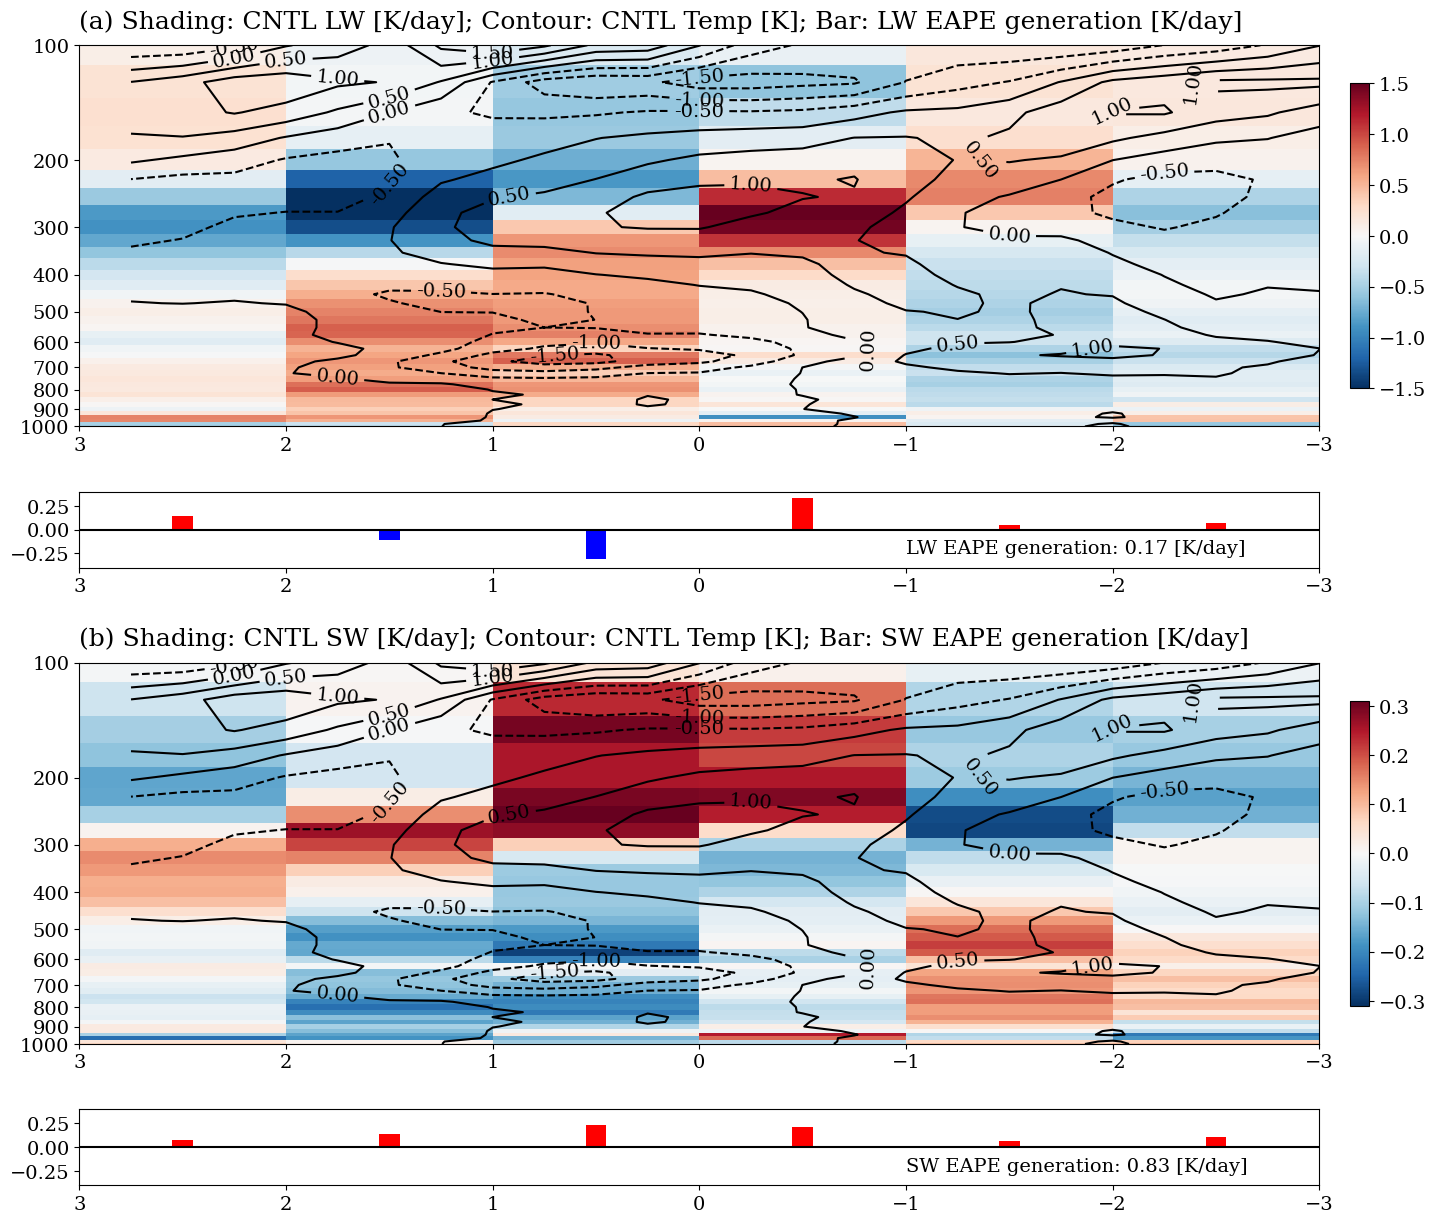

In [113]:
# Set global font settings
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

# Figure setting
fig = plt.figure(figsize=(16, 15))
gs = gridspec.GridSpec(4, 1, height_ratios=[1, 0.2, 1, 0.2], hspace=0.35)

# Upper penel (pcolormesh & contour)
ax0 = fig.add_subplot(gs[0])
lw_cf = ax0.pcolormesh(
    np.linspace(-2.5, 2.5, 6), dims["lev"],
    data_daily["lw"], cmap="RdBu_r", norm=TwoSlopeNorm(vcenter=0, vmin=-1.5, vmax=1.5),
)
t_cf = ax0.contour(
    np.linspace(-3, 2.75, 24), dims["lev"],
    data_comp["t"].T, colors="k", levels=np.arange(-2.5, 2.6, 0.5),
)
ax0.set_yscale("log")
ax0.set_xticks(np.linspace(-3, 3, 7))
ax0.set_yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10, dtype=int))
ax0.set_ylim(1000, 100)
ax0.set_xlim(3, -3)
ax0.text(3, 90, "(a) Shading: CNTL LW [K/day]; Contour: CNTL Temp [K]; Bar: LW EAPE generation [K/day]", fontsize=18)
ax0.clabel(t_cf, fmt="%1.2f", inline=True, fontsize=14)

# Add colorbar for ax0
cax0 = inset_axes(ax0, width="1.5%", height="80%", loc="center right",
                bbox_to_anchor=(0.04, 0, 1, 1),
                bbox_transform=ax0.transAxes, borderpad=0)
fig.colorbar(lw_cf, cax=cax0)


# Lower panel (LW bar plot)
ax1 = fig.add_subplot(gs[1], sharex=ax0)
lw_positive_cond = np.where(growth_rate_vint["lw"] > 0)[0]
lw_negative_cond = np.where(growth_rate_vint["lw"] < 0)[0]

ax1.bar(np.linspace(-2.5, 2.5, 6)[lw_positive_cond], growth_rate_vint["lw"][lw_positive_cond], width=0.1, color="red")
ax1.bar(np.linspace(-2.5, 2.5, 6)[lw_negative_cond], growth_rate_vint["lw"][lw_negative_cond], width=0.1, color="blue")
ax1.axhline(0, color="k")
ax1.set_yticks(np.linspace(-0.25, 0.25, 3))
ax1.set_xlim(3, -3)
ax1.set_ylim(-0.4, 0.4)
ax1.text(-1, -0.25, f"LW EAPE generation: {np.round(growth_rate_vint['lw'].sum(), 2)} [K/day]", fontsize=14)

# Align ax1 with ax0
pos0 = ax0.get_position()
pos1 = ax1.get_position()
ax1.set_position([pos1.x0, pos1.y0+0.01, pos0.width, pos1.height])

# Upper penel (pcolormesh & contour)
ax2 = fig.add_subplot(gs[2], sharex=ax0)
sw_cf = ax2.pcolormesh(
    np.linspace(-2.5, 2.5, 6), dims["lev"],
    data_daily["sw"], cmap="RdBu_r", norm=TwoSlopeNorm(vcenter=0, vmin=-0.31, vmax=0.31),
)
t_cf = ax2.contour(
    np.linspace(-3, 2.75, 24), dims["lev"],
    data_comp["t"].T, colors="k", levels=np.arange(-2.5, 2.6, 0.5),
)
ax2.set_yscale("log")
ax2.set_xticks(np.linspace(-3, 3, 7))
ax2.set_yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10, dtype=int))
ax2.set_ylim(1000, 100)
ax2.set_xlim(3, -3)
ax2.text(3, 90, "(b) Shading: CNTL SW [K/day]; Contour: CNTL Temp [K]; Bar: SW EAPE generation [K/day]", fontsize=18)
ax2.clabel(t_cf, fmt="%1.2f", inline=True, fontsize=14)

# Lower panel (LW bar plot)
ax3 = fig.add_subplot(gs[3], sharex=ax0)
sw_positive_cond = np.where(growth_rate_vint["sw"] > 0)[0]
sw_negative_cond = np.where(growth_rate_vint["sw"] < 0)[0]

ax3.bar(np.linspace(-2.5, 2.5, 6)[sw_positive_cond], growth_rate_vint["sw"][sw_positive_cond], width=0.1, color="red")
ax3.bar(np.linspace(-2.5, 2.5, 6)[sw_negative_cond], growth_rate_vint["sw"][sw_negative_cond], width=0.1, color="blue")
ax3.axhline(0, color="k")
ax3.set_yticks(np.linspace(-0.25, 0.25, 3))
ax3.set_xlim(3, -3)
ax3.set_ylim(-0.4, 0.4)
ax3.text(-1, -0.25, f"SW EAPE generation: {np.round(growth_rate_vint['sw'].sum(), 2)} [K/day]", fontsize=14)


# Add colorbar for ax0
cax0 = inset_axes(ax2, width="1.5%", height="80%", loc="center right",
                bbox_to_anchor=(0.04, 0, 1, 1),
                bbox_transform=ax2.transAxes, borderpad=0)
fig.colorbar(sw_cf, cax=cax0)

# Align ax1 with ax0
pos2 = ax2.get_position()
pos3 = ax3.get_position()
ax3.set_position([pos3.x0, pos3.y0+0.01, pos2.width, pos3.height])

plt.savefig("/home/b11209013/Bachelor_Thesis/Major/Figure/Figure02.png", dpi=300);
